## High Level Computer Vision 
### Exercise 2: Deep Neural Networks and Backpropagation

In [4]:
Name = ""
Matriculation_Number = ""

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
from resources.data_utils import get_CIFAR10_data
from resources.vis_utils import visualize_grid
#from resources.solutions import *
from resources.gradient_check import eval_numerical_gradient


Deep neural networks have shown staggering performances in various learning tasks, including computer vision, natural language processing, and sound processing. They have made the model design more flexible by enabling end-to-end training.

In this exercise, we get to have a first hands-on experience with neural network training. Many frameworks (e.g., PyTorch, Tensorflow, Caffe) allow easy usage of deep neural networks without precise knowledge of the inner workings of backpropagation and gradient descent algorithms. While these are very useful tools, it is important to get a good understanding of how to implement basic network training from scratch before using these libraries to speed up the process. For this purpose, we will implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations in questions 1 to 3. In question 4, we will use a popular deep learning library, PyTorch, to do the same and understand the advantages offered by using such tools.

As a benchmark to test our models, we consider an image classification task using the widely used CIFAR-10 dataset. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to code and train a parametrized model for classifying those images. This involves

- Implementing the feedforward model (Question 1).
- Implementing the backpropagation algorithm (gradient computation) (Question 2).
- Training the model using stochastic gradient descent and improving the model training with better hyper-parameters (Question 3).
- Using the PyTorch Library to implement the above and experiment with deeper networks (Question 4).

A note on notation: Throughout the exercise, notation $v_i$ is used to denote the $i$-th element of vector $v$.

### Question 1: Implementing the feedforward model (10 points)

In this question, we will implement a two-layered neural network architecture and the loss function to train it.

<img src="./resources/fig1.png" width="900" align=left>

**Model architecture.** Our architecture is shown in Fig.1. It has an input layer and two model layers – a hidden and an output layer. We start with randomly generated toy inputs of four dimensions and the number of classes K = 3 to build our model in Q1 and Q2, and in Q3 use images from the CIFAR-10 dataset to test our model on a real-world task. Hence input layer is 4-dimensional for now.

In the hidden layer, there are ten units. The input layer and the hidden
layer are connected via linear weighting matrix $W^{(1)}\in\mathbb{R}^{10\times
4}$ and the bias term $b^{(1)}\in\mathbb{R}^{10}$. The parameters $W^{(1)}$
and $b^{(1)}$ are to be learnt later on. A linear operation is performed,
$W^{(1)}x+b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then
followed by a relu non-linear activation $\phi$, applied element-wise on each
unit, resulting in the activations $a^{(2)} = \phi(z^{(2)})$. Relu function has
the following form:
\begin{equation}
\label{eq:sigmoid}
\phi(u) =  \begin{cases}
      u, & \text{if}\ u\geq0 \\
      0, & \text{if}\ u <0
    \end{cases}
\end{equation}

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)}=W^{(2)}a^{(2)}+b^{(2)}$, where $W^{(2)}\in\mathbb{R}^{3\times 10}$ and $b^{(2)}\in\mathbb{R}^{3}$; it is followed by the softmax activation to result in $a^{(3)}=\psi(z^{(3)})$. The softmax function is defined by:
\begin{equation}
\psi(u)_i =  \frac{\exp^{u_i}}{\sum_j{\exp^{u_j}}} 
\end{equation}

The final functional form of our model is thus defined by
\begin{align}
\label{eq:feedforward-model-start}
a^{(1)} & = x \\\
z^{(2)} & = W^{(1)}a^{(1)}+b^{(1)} \\
a^{(2)} & = \phi(z^{(2)}) \\
z^{(3)} & = W^{(2)}a^{(2)}+b^{(2)} \\
\label{eq:feedforward-model-end}
f_\theta(x) := a^{(3)} & = \psi(z^{(3)}),
\end{align}
which takes a flattened 4 dimensional vector as input and outputs a $3$ dimensional vector, each entry in the output $f_k(x)$ representing the probability of image $x$ corresponding to the class $k$. We summarily indicate all the network parameters by $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.

**Implementation.** We are now ready to implement the feedforward neural network.

a) Implement the feedforward model. Verify that the scores you generate for the toy inputs match the correct scores. (5 points)

In [6]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def forward(self, X):
        """
        Compute the final outputs for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        A matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # fcl
        z2 = X @ W1 + b1
        # relu
        a2 = np.multiply(z2, (z2 > 0))
        # fcl
        z3 = a2 @ W2 + b2
        # softmax
        scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        return scores       

In [7]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

scores = net.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

assert math.isclose(np.sum(np.abs(scores - correct_scores)), 0,  abs_tol=1e-6)

Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Difference between your scores and correct scores:
2.9173411658645065e-08


b) We later guide the neural network parameters
$\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$ to fit the given data and label
pairs. We do so by minimising the loss function. A popular choice of the loss
function for training neural networks for multi-class classification is the
cross-entropy loss. For a single input sample $x_i$, with label $y_i$, the loss
function is defined as:
\begin{align}
J(\theta, x_i, y_i) &= -\log{P(Y=y_i,X=x_i)} \\
                    &= -\log{f_\theta(x_i)_{y_i}} \\
                    &= -\log{\psi(z^{(3)})_{y_i}} \\
J(\theta, x_i, y_i) &= -\log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum^K_j{\exp^{z^{(3)}_j}}}\right]
\label{eq:log-loss-softmax}
\end{align}

Averaging over the whole training set, we get 
\begin{equation}
\label{eq:log-loss-softmax-empirical}
J(\theta,\{x_i,y_i\}_{i=1}^{N}) = \frac{1}{N} \sum_{i=1}^N 
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right],
\end{equation}
where $K$ is the number of classes. Note that if the model has perfectly fitted
to the data (\emph{i.e.} $f_\theta^k(x_i)=1$ whenever $x_i$ belongs to class $k$ and 0
otherwise), then $J$ attains the minimum of $0$. 


Apart from trying to correctly predict the label, we have to prevent
overfitting the model to the current training data.  This is done by encoding
our prior belief that the correct model should be simple (Occam's razor); we
add an $L_2$ regularisation term over the model parameters $\theta$.
Specifically, the loss function is defined by:
\begin{equation}
\label{eq:log-loss-empirical-regularised}
\tilde{J}(\theta) = \frac{1}{N} \sum_{i=1}^N
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right]
+\lambda \left(||W^{(1)}||_2^2 + ||W^{(2)}||_2^2 \right),
\end{equation}
where $||\cdot||_2^2$ is the squared $L_2$ norm. For example,
\begin{equation}
\label{eq:L2-term}
||W^{(1)}||_2^2 = 
\sum_{p=1}^{10} \sum_{q=1}^{4} W_{pq}^{(1)2}
\end{equation}
By changing the value of $\lambda$ it is possible to give weights to your prior belief on the degree of simplicity (regularity) of the true model. 

Implement the final loss function and let it return the loss value. Verify the code by
running and matching the output cost $1.30378789133$. (5 points)

In [8]:
class TwoLayerNetv2(TwoLayerNet):
    def compute_loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # fcl
        z2 = X @ W1 + b1
        # relu
        a2 = np.multiply(z2, (z2 > 0))
        # fcl
        z3 = a2 @ W2 + b2
        # softmax
        scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # calculate regularization penalty
        r1 = reg * np.sum(np.square(W1))
        r2 = reg * np.sum(np.square(W2))
        # compute softmax loss
        target_scores = scores[np.arange(y.size), y]
        logs = np.log(target_scores+1e-8)
        loss = (-np.sum(logs) / float(N)) + r1 + r2
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss

In [9]:
# Compute loss in the same function
def init_toy_model_v2():
    np.random.seed(0)
    return TwoLayerNetv2(input_size, hidden_size, num_classes, std=1e-1)

net_v2 = init_toy_model_v2()
loss = net_v2.compute_loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

assert math.isclose(np.sum(np.abs(loss - correct_loss)), 0,  abs_tol=1e-6)

Difference between your loss and correct loss:
3.679019733304756e-08


### Question 2: Backpropagation (15 points)

We train the model by solving
\begin{equation}
\label{eq:train-main}
\underset{\theta}{\min} \,\,  \tilde{J}(\theta)
\end{equation}
via stochastic gradient descent. Therefore, We need an efficient computation of the gradients $\nabla_\theta \tilde{J}(\theta)$. We use backpropagation of top layer error signals to the parameters $\theta$ at different layers.

In this question, you will be required to implement the backpropagation algorithm yourself from pseudocode. We will give a high-level description of what is happening in each line.

For those who are interested in the robust derivation of the algorithm, we include the optional exercise on the derivation of the backpropagation algorithm. A piece of prior knowledge of standard vector calculus, including the chain rule, would be helpful. 


**Backpropagation.** The backpropagation algorithm is simply a sequential application of the chain rule. It is applicable to any (sub-) differentiable model that is a composition of simple building blocks. In this exercise, we focus on the architecture with stacked layers of linear transformation + relu non-linear activation.

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x, y)$, we first run the feedforward to compute all the activations throughout the network, including the output value of the model $f_\theta(x)$ and the loss $J$. Then, for each parameter in the model, we want to compute the effect that parameter has on the loss. This is done by computing the derivatives of the loss w.r.t for each model parameter.

The backpropagation algorithm is performed from the top of the network (loss layer) to the bottom. It sequentially computes the gradient of the loss function with respect to each layer's activations and parameters.

Let’s start by deriving the gradients of the un-regularized loss function w.r.t final layer activations $z^{(3)}$. We will then use this in the chain rule to compute analytical expressions for gradients of all the model parameters.

(a) Verify that the loss function (in Q1) has the gradient w.r.t $z^{(3)}$ as below.
\begin{equation}
\frac{\partial J}{\partial z^{(3)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) = \frac{1}{N}\left(\psi(z^{(3)}) - \Delta\right), 
\end{equation}
where $\Delta$ is a matrix of $N\times K$ dimensions with 
\begin{equation}
        \Delta_{ij} = \begin{cases}
        1, & \text{if}\ y_i =j \\
                0, & \text{otherwise}
\end{cases}
\end{equation}
(please write your answer in the block below, 2 points)

Derivative of mse loss

b) To compute the effect of the weight matrix $W^{(2)}$ on the loss (in Q1) incurred by the network, we compute the
partial derivatives of the loss function with respect to $W^{2}$.  This is done
by applying the chain rule. Verify that the partial derivative of the loss
w.r.t $W^{(2)}$ is  
\begin{align}
\label{eq:grad-loss-multi}
\frac{\partial J}{\partial W^{(2)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) &= \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial W^{(2)}} \\
&= \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'}
\end{align}

Similary, verify that the regularized loss has the derivatives

\begin{equation}
\frac{\partial \tilde{J}}{\partial W^{(2)}} = \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'} + 2\lambda W^{(2)}
\end{equation}

(please write your answer in the block below, 2 points)

We apply chain rule and then easy derivatives

c) We can repeatedly apply chain rule as discussed above to obtain the derivatives of the loss with respect to all the parameters of the model $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.
Dervive the expressions for the derivatives of the regularized loss (in Q1) w.r.t $W^{(1)}$, $b^{(1)}$, $b^{(2)}$ now.
(please write your answer in the block below, 6 points)

d) Using the expressions you obtained for the derivatives of the loss w.r.t model
parameters, implement the back-propagation algorithm. Run the code and verify that the
gradients you obtained are correct using numerical gradients (already
implemented in the code). The maximum relative error between the gradients you
compute and the numerical gradients should be less than 1e-8 for all parameters.
(5 points)

In [10]:
class TwoLayerNetv3(TwoLayerNetv2):
    def back_propagation(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D= X.shape


        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****             
        # fcl
        z2 = X @ W1 + b1
        # relu
        a2 = np.multiply(z2, (z2 > 0))
        # fcl
        z3 = a2 @ W2 + b2
        # softmax
        scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        r1 = reg * np.sum(np.square(W1))
        r2 = reg * np.sum(np.square(W2))
        target_scores = scores[np.arange(y.size), y]
        logs = np.log(target_scores+1e-8)
        loss = (-np.sum(logs) / float(N)) + r1 + r2
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        targets = np.zeros_like(scores)
        targets[np.arange(y.size), y] = 1
        grad_loss = (scores - targets) / N
        grads['W2'] = a2.T @ grad_loss + 2 * reg * W2
        grads['b2'] = np.sum(grad_loss, axis=0)
        grad_a2 = grad_loss @ W2.T
        grad_z2 = np.multiply((z2>0), grad_a2)
        grads['W1'] = X.T @ grad_z2 + 2 * reg * W1
        grads['b1'] = np.sum(grad_z2, axis=0)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

In [11]:
# Compute the gradient
def init_toy_model_v3():
    np.random.seed(0)
    return TwoLayerNetv3(input_size, hidden_size, num_classes, std=1e-1)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

net_v3 = init_toy_model_v3()

loss, grads = net_v3.back_propagation(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net_v3.back_propagation(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net_v3.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 6.799706e-08
b2 max relative error: 3.065721e-08
W1 max relative error: 1.914147e-06
b1 max relative error: 1.313493e-07


### Question 3: Stochastic gradient descent training (10 points)

We have implemented the backpropagation algorithm for computing the parameter gradients and have verified that it indeed gives the correct gradient. We are now ready to train the network. We solve Eq.15 with the stochastic gradient descent.

Typically neural networks are large and are trained with millions of data
points. It is thus often infeasible to compute the gradient $\nabla_\theta
\tilde{J}(\theta)$ that requires the accumulation of the gradient over the
entire training set. Stochastic gradient descent addresses this problem by
simply accumulating the gradient over a small random subset of the training
samples (minibatch) at each iteration. Specifically, the algorithm is as
follows,

<img src="./resources/alg1.png" width="900" align=left>

where the gradient $\nabla_\theta \tilde{J}(\theta,\{(X^\prime_j,y^\prime_j)\}_{j=1}^B)$ is computed only on the current randomly sampled batch.

Intuitively, $v = -\nabla_\theta \tilde{J}(\theta^{(t-1)})$ gives the direction
to which the loss $\tilde{J}$ decreases the most (locally), and therefore we
follow that direction by updating the parameters towards that direction
$\theta^{(t)} = \theta^{(t-1)} + v$. 

a) Implement the stochastic gradient descent algorithm and run the training on the toy data. Your model
should be able to  obtain loss <= 0.02 on the training set and the training
curve should look similar to the one shown in figure 2.

<img src="./resources/fig2.png" width="500" align=left>

In [12]:
class TwoLayerNetv4(TwoLayerNetv3):
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = X
            y_batch = y

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            batch_idxs = np.random.choice(np.arange(y.size), size=batch_size, replace=True)
            X_batch = X[batch_idxs]
            y_batch = y[batch_idxs]
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.back_propagation(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            for key, value in grads.items(): 
                self.params[key] = self.params[key] - learning_rate * value
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }
    
    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        scores = self.forward(X)
        y_pred = np.argmax(scores, axis=1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

Final training loss:  0.01714959776498867


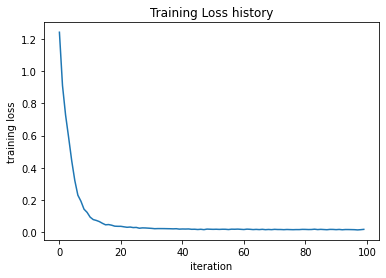

In [13]:
def init_toy_model_v4():
    np.random.seed(0)
    return TwoLayerNetv4(input_size, hidden_size, num_classes, std=1e-1)

net_v4 = init_toy_model_v4()
stats = net_v4.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

b) We are now ready to train our model on a real image dataset. For this, we will use
the CIFAR-10 dataset.  Since the images are of size $32\times 32$ pixels with 3
color channels, this gives us 3072 input layer units, represented by a vector
$x\in\mathbb{R}^{3072}$. The code to load the data and train the model is provided with
some default hyperparameters. With default
hyperparameters, if previous questions have been done correctly, you should get
a validation set accuracy of about 29\%. This is very poor.
Your task is to debug the model training and come up with better hyperparameters
to improve the performance on the validation set.
Visualize the training and validation performance curves to help with this analysis.
There are several pointers provided in the comments to 
help you understand why the network might be underperforming.
Once you have tuned your hyperparameters, and get validation accuracy greater
than 48\% run your best model on the test set once and report the performance.

**Download CIFAR-10 using this link: <http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz>**
<br />
**Decompress the downloaded dataset, and put the `cifar-10-batches-py` folder in the foleder `datasets`**

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


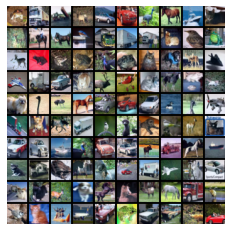

iteration 0 / 1000: loss 2.303005
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.299343
iteration 300 / 1000: loss 2.275269
iteration 400 / 1000: loss 2.172354
iteration 500 / 1000: loss 2.141847
iteration 600 / 1000: loss 2.087006
iteration 700 / 1000: loss 2.060840
iteration 800 / 1000: loss 2.023442
iteration 900 / 1000: loss 1.964439
Validation accuracy:  0.28


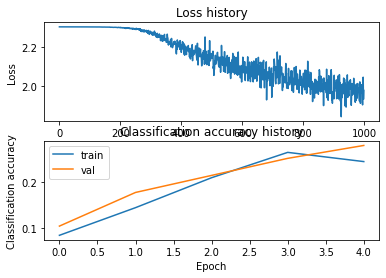

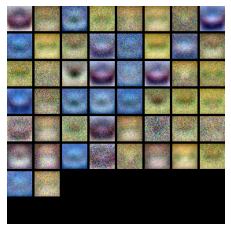

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302550
iteration 100 / 4000: loss 2.301704
iteration 200 / 4000: loss 2.293356
iteration 300 / 4000: loss 2.242719
iteration 400 / 4000: loss 2.168152
iteration 500 / 4000: loss 2.172310
iteration 600 / 4000: loss 2.059008
iteration 700 / 4000: loss 2.012082
iteration 800 / 4000: loss 1.932318
iteration 900 / 4000: loss 1.897133
iteration 1000 / 4000: loss 1.932338
iteration 1100 / 4000: loss 1.869475
iteration 1200 / 4000: loss 1.938080
iteration 1300 / 4000: loss 1.844425
iteration 1400 / 4000: loss 1.802413
iteration 1500 / 4000: loss 1.973339
iteration 1600 / 4000: loss 1.867543
iteration 1700 / 4000: loss 1.862045
iteration 1800 / 4000: loss 1.808449
iteration 1900 / 4000: loss 1.835020
iteration 2000 / 4000: loss 1.777022
iteration 2100 / 4000: loss 1.832758
iteration 2200 / 4000: loss 1.774683
iteration 2300 / 4000: loss 1.905685
iterati

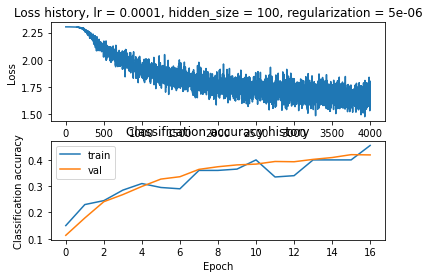

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302610
iteration 100 / 4000: loss 2.301807
iteration 200 / 4000: loss 2.296645
iteration 300 / 4000: loss 2.230709
iteration 400 / 4000: loss 2.206443
iteration 500 / 4000: loss 2.120849
iteration 600 / 4000: loss 2.054974
iteration 700 / 4000: loss 1.952185
iteration 800 / 4000: loss 1.944603
iteration 900 / 4000: loss 1.878577
iteration 1000 / 4000: loss 2.078001
iteration 1100 / 4000: loss 1.897419
iteration 1200 / 4000: loss 1.933073
iteration 1300 / 4000: loss 1.926745
iteration 1400 / 4000: loss 1.857239
iteration 1500 / 4000: loss 1.889223
iteration 1600 / 4000: loss 1.783116
iteration 1700 / 4000: loss 1.746697
iteration 1800 / 4000: loss 1.805028
iteration 1900 / 4000: loss 1.798319
iteration 2000 / 4000: loss 1.753755
iteration 2100 / 4000: loss 1.735810
iteration 2200 / 4000: loss 1.781121
iteration 2300 / 4000: loss 1.707141
iterat

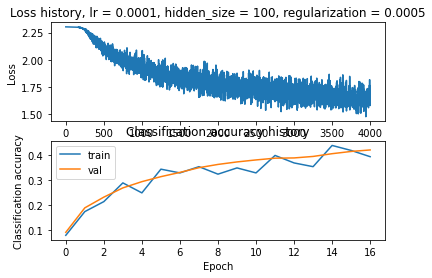

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302605
iteration 100 / 4000: loss 2.301692
iteration 200 / 4000: loss 2.292193
iteration 300 / 4000: loss 2.256761
iteration 400 / 4000: loss 2.148735
iteration 500 / 4000: loss 2.125421
iteration 600 / 4000: loss 2.143675
iteration 700 / 4000: loss 2.007604
iteration 800 / 4000: loss 2.021503
iteration 900 / 4000: loss 1.950162
iteration 1000 / 4000: loss 1.899597
iteration 1100 / 4000: loss 1.790305
iteration 1200 / 4000: loss 1.854263
iteration 1300 / 4000: loss 1.835666
iteration 1400 / 4000: loss 1.878692
iteration 1500 / 4000: loss 1.841879
iteration 1600 / 4000: loss 1.823705
iteration 1700 / 4000: loss 1.800172
iteration 1800 / 4000: loss 1.762597
iteration 1900 / 4000: loss 1.797067
iteration 2000 / 4000: loss 1.768880
iteration 2100 / 4000: loss 1.879954
iteration 2200 / 4000: loss 1.676353
iteration 2300 / 4000: loss 1.783849
iterat

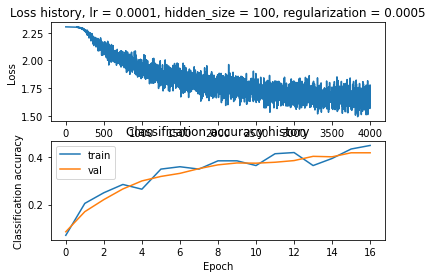

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302531
iteration 100 / 4000: loss 2.299817
iteration 200 / 4000: loss 2.273398
iteration 300 / 4000: loss 2.195986
iteration 400 / 4000: loss 2.159555
iteration 500 / 4000: loss 2.111142
iteration 600 / 4000: loss 1.996284
iteration 700 / 4000: loss 2.031000
iteration 800 / 4000: loss 1.962523
iteration 900 / 4000: loss 1.880836
iteration 1000 / 4000: loss 1.847352
iteration 1100 / 4000: loss 1.942023
iteration 1200 / 4000: loss 1.885931
iteration 1300 / 4000: loss 1.936352
iteration 1400 / 4000: loss 1.892551
iteration 1500 / 4000: loss 1.833075
iteration 1600 / 4000: loss 1.666772
iteration 1700 / 4000: loss 1.747618
iteration 1800 / 4000: loss 1.844831
iteration 1900 / 4000: loss 1.834271
iteration 2000 / 4000: loss 1.719556
iteration 2100 / 4000: loss 1.723769
iteration 2200 / 4000: loss 1.748839
iteration 2300 / 4000: loss 1.806977
iterati

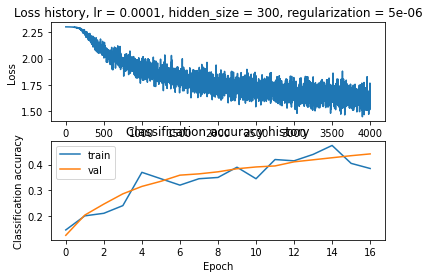

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302589
iteration 100 / 4000: loss 2.300505
iteration 200 / 4000: loss 2.285155
iteration 300 / 4000: loss 2.197712
iteration 400 / 4000: loss 2.129894
iteration 500 / 4000: loss 2.058443
iteration 600 / 4000: loss 2.027448
iteration 700 / 4000: loss 1.959235
iteration 800 / 4000: loss 1.963447
iteration 900 / 4000: loss 1.915666
iteration 1000 / 4000: loss 1.889613
iteration 1100 / 4000: loss 1.885457
iteration 1200 / 4000: loss 1.794401
iteration 1300 / 4000: loss 1.862002
iteration 1400 / 4000: loss 1.761706
iteration 1500 / 4000: loss 1.875588
iteration 1600 / 4000: loss 1.819012
iteration 1700 / 4000: loss 1.768617
iteration 1800 / 4000: loss 1.746187
iteration 1900 / 4000: loss 1.804974
iteration 2000 / 4000: loss 1.809052
iteration 2100 / 4000: loss 1.772068
iteration 2200 / 4000: loss 1.756264
iteration 2300 / 4000: loss 1.792432
iterat

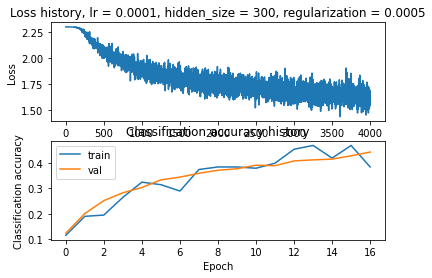

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302572
iteration 100 / 4000: loss 2.299617
iteration 200 / 4000: loss 2.274569
iteration 300 / 4000: loss 2.216676
iteration 400 / 4000: loss 2.090508
iteration 500 / 4000: loss 2.085141
iteration 600 / 4000: loss 1.996253
iteration 700 / 4000: loss 1.964857
iteration 800 / 4000: loss 1.974501
iteration 900 / 4000: loss 1.990239
iteration 1000 / 4000: loss 1.855855
iteration 1100 / 4000: loss 1.855946
iteration 1200 / 4000: loss 1.776551
iteration 1300 / 4000: loss 1.920031
iteration 1400 / 4000: loss 1.744846
iteration 1500 / 4000: loss 1.832579
iteration 1600 / 4000: loss 1.865610
iteration 1700 / 4000: loss 1.825523
iteration 1800 / 4000: loss 1.741717
iteration 1900 / 4000: loss 1.697256
iteration 2000 / 4000: loss 1.742174
iteration 2100 / 4000: loss 1.714011
iteration 2200 / 4000: loss 1.658403
iteration 2300 / 4000: loss 1.761063
iterat

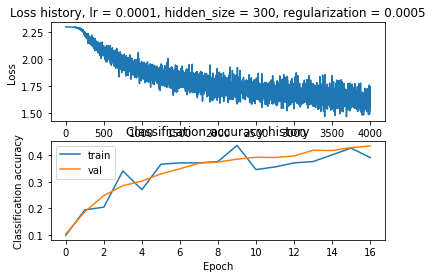

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302553
iteration 100 / 4000: loss 2.297935
iteration 200 / 4000: loss 2.271311
iteration 300 / 4000: loss 2.206021
iteration 400 / 4000: loss 2.083126
iteration 500 / 4000: loss 1.988759
iteration 600 / 4000: loss 1.988198
iteration 700 / 4000: loss 1.972073
iteration 800 / 4000: loss 1.906583
iteration 900 / 4000: loss 1.958553
iteration 1000 / 4000: loss 1.869264
iteration 1100 / 4000: loss 1.809867
iteration 1200 / 4000: loss 1.786430
iteration 1300 / 4000: loss 1.903001
iteration 1400 / 4000: loss 1.747172
iteration 1500 / 4000: loss 1.713542
iteration 1600 / 4000: loss 1.727086
iteration 1700 / 4000: loss 1.811764
iteration 1800 / 4000: loss 1.741505
iteration 1900 / 4000: loss 1.709251
iteration 2000 / 4000: loss 1.716371
iteration 2100 / 4000: loss 1.696834
iteration 2200 / 4000: loss 1.754987
iteration 2300 / 4000: loss 1.639556
iterati

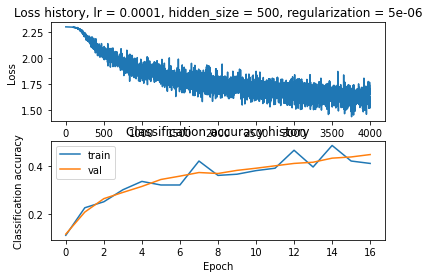

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302609
iteration 100 / 4000: loss 2.298573
iteration 200 / 4000: loss 2.273620
iteration 300 / 4000: loss 2.167383
iteration 400 / 4000: loss 2.071066
iteration 500 / 4000: loss 2.086748
iteration 600 / 4000: loss 2.041561
iteration 700 / 4000: loss 1.967807
iteration 800 / 4000: loss 1.922592
iteration 900 / 4000: loss 1.886498
iteration 1000 / 4000: loss 1.845307
iteration 1100 / 4000: loss 1.822587
iteration 1200 / 4000: loss 1.870909
iteration 1300 / 4000: loss 1.871484
iteration 1400 / 4000: loss 1.700754
iteration 1500 / 4000: loss 1.896274
iteration 1600 / 4000: loss 1.781664
iteration 1700 / 4000: loss 1.804527
iteration 1800 / 4000: loss 1.720199
iteration 1900 / 4000: loss 1.840390
iteration 2000 / 4000: loss 1.706755
iteration 2100 / 4000: loss 1.727566
iteration 2200 / 4000: loss 1.603997
iteration 2300 / 4000: loss 1.641978
iterat

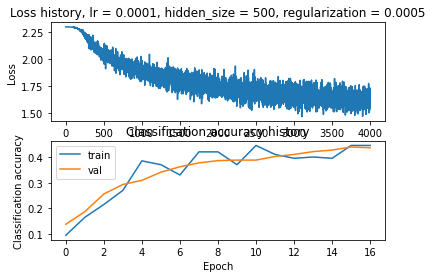

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302499
iteration 100 / 4000: loss 2.296757
iteration 200 / 4000: loss 2.271771
iteration 300 / 4000: loss 2.185679
iteration 400 / 4000: loss 2.132980
iteration 500 / 4000: loss 2.046395
iteration 600 / 4000: loss 2.077232
iteration 700 / 4000: loss 1.929623
iteration 800 / 4000: loss 2.012296
iteration 900 / 4000: loss 1.929417
iteration 1000 / 4000: loss 1.934349
iteration 1100 / 4000: loss 1.863132
iteration 1200 / 4000: loss 1.775548
iteration 1300 / 4000: loss 1.758391
iteration 1400 / 4000: loss 1.792076
iteration 1500 / 4000: loss 1.904636
iteration 1600 / 4000: loss 1.776380
iteration 1700 / 4000: loss 1.755971
iteration 1800 / 4000: loss 1.791286
iteration 1900 / 4000: loss 1.645349
iteration 2000 / 4000: loss 1.646201
iteration 2100 / 4000: loss 1.742612
iteration 2200 / 4000: loss 1.834358
iteration 2300 / 4000: loss 1.780383
iterat

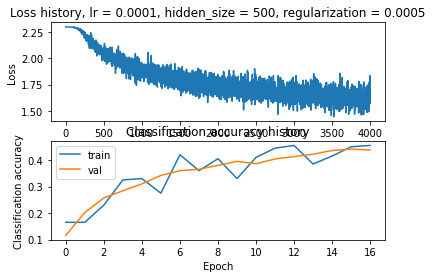

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302482
iteration 100 / 4000: loss 2.289591
iteration 200 / 4000: loss 2.233216
iteration 300 / 4000: loss 2.160899
iteration 400 / 4000: loss 2.060275
iteration 500 / 4000: loss 2.028745
iteration 600 / 4000: loss 2.015540
iteration 700 / 4000: loss 2.011669
iteration 800 / 4000: loss 1.939600
iteration 900 / 4000: loss 1.870131
iteration 1000 / 4000: loss 1.834086
iteration 1100 / 4000: loss 1.856437
iteration 1200 / 4000: loss 1.815517
iteration 1300 / 4000: loss 1.753143
iteration 1400 / 4000: loss 1.770983
iteration 1500 / 4000: loss 1.763834
iteration 1600 / 4000: loss 1.797918
iteration 1700 / 4000: loss 1.671241
iteration 1800 / 4000: loss 1.729345
iteration 1900 / 4000: loss 1.682320
iteration 2000 / 4000: loss 1.762987
iteration 2100 / 4000: loss 1.753276
iteration 2200 / 4000: loss 1.775579
iteration 2300 / 4000: loss 1.673050
iterat

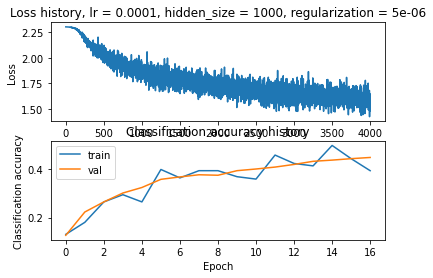

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302674
iteration 100 / 4000: loss 2.292729
iteration 200 / 4000: loss 2.228117
iteration 300 / 4000: loss 2.139271
iteration 400 / 4000: loss 2.106251
iteration 500 / 4000: loss 1.944942
iteration 600 / 4000: loss 1.962616
iteration 700 / 4000: loss 1.962598
iteration 800 / 4000: loss 1.875915
iteration 900 / 4000: loss 1.927047
iteration 1000 / 4000: loss 1.857082
iteration 1100 / 4000: loss 1.824019
iteration 1200 / 4000: loss 1.770147
iteration 1300 / 4000: loss 1.805108
iteration 1400 / 4000: loss 1.724088
iteration 1500 / 4000: loss 1.820939
iteration 1600 / 4000: loss 1.715944
iteration 1700 / 4000: loss 1.753224
iteration 1800 / 4000: loss 1.774779
iteration 1900 / 4000: loss 1.770723
iteration 2000 / 4000: loss 1.713064
iteration 2100 / 4000: loss 1.761776
iteration 2200 / 4000: loss 1.779932
iteration 2300 / 4000: loss 1.640135
itera

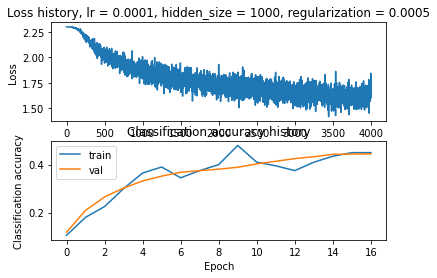

---------------------------------
Learning rate:  0.0001
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302483
iteration 100 / 4000: loss 2.293897
iteration 200 / 4000: loss 2.236054
iteration 300 / 4000: loss 2.175462
iteration 400 / 4000: loss 2.101627
iteration 500 / 4000: loss 2.074915
iteration 600 / 4000: loss 1.929994
iteration 700 / 4000: loss 1.976906
iteration 800 / 4000: loss 1.880348
iteration 900 / 4000: loss 1.920537
iteration 1000 / 4000: loss 1.799885
iteration 1100 / 4000: loss 1.802472
iteration 1200 / 4000: loss 1.941332
iteration 1300 / 4000: loss 1.766159
iteration 1400 / 4000: loss 1.789854
iteration 1500 / 4000: loss 1.794607
iteration 1600 / 4000: loss 1.763128
iteration 1700 / 4000: loss 1.784380
iteration 1800 / 4000: loss 1.659561
iteration 1900 / 4000: loss 1.711619
iteration 2000 / 4000: loss 1.810795
iteration 2100 / 4000: loss 1.661357
iteration 2200 / 4000: loss 1.656888
iteration 2300 / 4000: loss 1.770494
itera

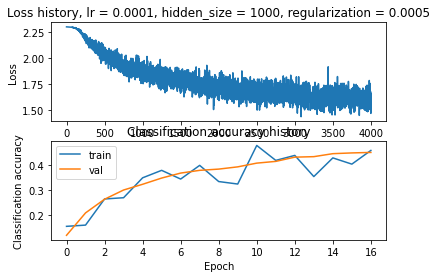

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302576
iteration 100 / 4000: loss 1.956989
iteration 200 / 4000: loss 1.730546
iteration 300 / 4000: loss 1.582735
iteration 400 / 4000: loss 1.600210
iteration 500 / 4000: loss 1.640790
iteration 600 / 4000: loss 1.540909
iteration 700 / 4000: loss 1.491418
iteration 800 / 4000: loss 1.430662
iteration 900 / 4000: loss 1.499312
iteration 1000 / 4000: loss 1.454192
iteration 1100 / 4000: loss 1.406705
iteration 1200 / 4000: loss 1.397108
iteration 1300 / 4000: loss 1.354100
iteration 1400 / 4000: loss 1.245947
iteration 1500 / 4000: loss 1.396313
iteration 1600 / 4000: loss 1.329661
iteration 1700 / 4000: loss 1.275030
iteration 1800 / 4000: loss 1.349795
iteration 1900 / 4000: loss 1.359785
iteration 2000 / 4000: loss 1.236289
iteration 2100 / 4000: loss 1.203701
iteration 2200 / 4000: loss 1.109659
iteration 2300 / 4000: loss 1.174772
iteratio

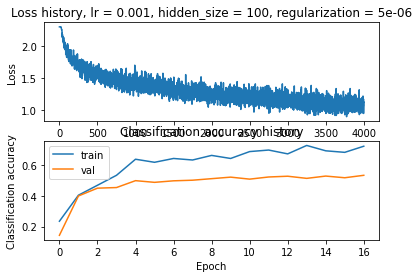

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302603
iteration 100 / 4000: loss 1.883845
iteration 200 / 4000: loss 1.724244
iteration 300 / 4000: loss 1.606184
iteration 400 / 4000: loss 1.572771
iteration 500 / 4000: loss 1.621749
iteration 600 / 4000: loss 1.513490
iteration 700 / 4000: loss 1.586547
iteration 800 / 4000: loss 1.507438
iteration 900 / 4000: loss 1.423850
iteration 1000 / 4000: loss 1.258190
iteration 1100 / 4000: loss 1.548333
iteration 1200 / 4000: loss 1.312677
iteration 1300 / 4000: loss 1.410251
iteration 1400 / 4000: loss 1.209101
iteration 1500 / 4000: loss 1.315991
iteration 1600 / 4000: loss 1.351632
iteration 1700 / 4000: loss 1.214907
iteration 1800 / 4000: loss 1.385621
iteration 1900 / 4000: loss 1.326418
iteration 2000 / 4000: loss 1.198818
iteration 2100 / 4000: loss 1.389888
iteration 2200 / 4000: loss 1.213199
iteration 2300 / 4000: loss 1.161638
iterati

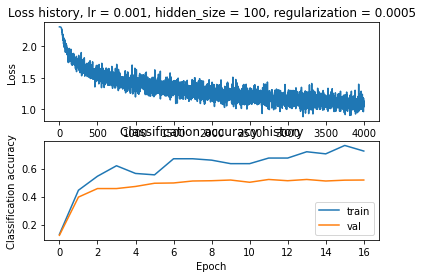

---------------------------------
Learning rate:  0.001
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302606
iteration 100 / 4000: loss 1.946580
iteration 200 / 4000: loss 1.722304
iteration 300 / 4000: loss 1.792056
iteration 400 / 4000: loss 1.712749
iteration 500 / 4000: loss 1.517548
iteration 600 / 4000: loss 1.498091
iteration 700 / 4000: loss 1.425509
iteration 800 / 4000: loss 1.468756
iteration 900 / 4000: loss 1.372338
iteration 1000 / 4000: loss 1.417736
iteration 1100 / 4000: loss 1.378735
iteration 1200 / 4000: loss 1.322237
iteration 1300 / 4000: loss 1.330170
iteration 1400 / 4000: loss 1.291594
iteration 1500 / 4000: loss 1.302028
iteration 1600 / 4000: loss 1.409553
iteration 1700 / 4000: loss 1.202347
iteration 1800 / 4000: loss 1.178988
iteration 1900 / 4000: loss 1.212751
iteration 2000 / 4000: loss 1.191623
iteration 2100 / 4000: loss 1.127465
iteration 2200 / 4000: loss 1.224917
iteration 2300 / 4000: loss 1.105412
iterati

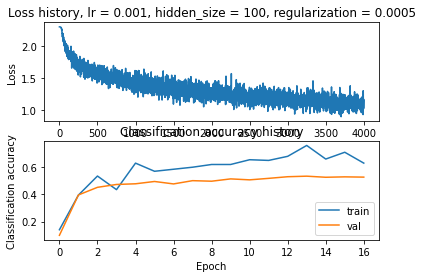

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302572
iteration 100 / 4000: loss 1.812609
iteration 200 / 4000: loss 1.825833
iteration 300 / 4000: loss 1.740329
iteration 400 / 4000: loss 1.601403
iteration 500 / 4000: loss 1.562290
iteration 600 / 4000: loss 1.541511
iteration 700 / 4000: loss 1.337442
iteration 800 / 4000: loss 1.357915
iteration 900 / 4000: loss 1.468100
iteration 1000 / 4000: loss 1.356472
iteration 1100 / 4000: loss 1.343751
iteration 1200 / 4000: loss 1.352241
iteration 1300 / 4000: loss 1.395559
iteration 1400 / 4000: loss 1.284002
iteration 1500 / 4000: loss 1.264840
iteration 1600 / 4000: loss 1.188290
iteration 1700 / 4000: loss 1.164217
iteration 1800 / 4000: loss 1.149043
iteration 1900 / 4000: loss 1.177541
iteration 2000 / 4000: loss 1.204322
iteration 2100 / 4000: loss 1.217617
iteration 2200 / 4000: loss 1.103210
iteration 2300 / 4000: loss 1.071424
iteratio

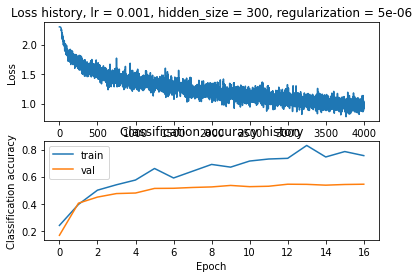

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302588
iteration 100 / 4000: loss 1.971488
iteration 200 / 4000: loss 1.803125
iteration 300 / 4000: loss 1.580534
iteration 400 / 4000: loss 1.662320
iteration 500 / 4000: loss 1.519267
iteration 600 / 4000: loss 1.401366
iteration 700 / 4000: loss 1.310968
iteration 800 / 4000: loss 1.312361
iteration 900 / 4000: loss 1.383629
iteration 1000 / 4000: loss 1.289025
iteration 1100 / 4000: loss 1.331874
iteration 1200 / 4000: loss 1.281414
iteration 1300 / 4000: loss 1.466513
iteration 1400 / 4000: loss 1.269686
iteration 1500 / 4000: loss 1.197307
iteration 1600 / 4000: loss 1.355501
iteration 1700 / 4000: loss 1.248655
iteration 1800 / 4000: loss 1.304076
iteration 1900 / 4000: loss 1.259806
iteration 2000 / 4000: loss 1.265827
iteration 2100 / 4000: loss 1.126881
iteration 2200 / 4000: loss 1.188949
iteration 2300 / 4000: loss 1.170388
iterati

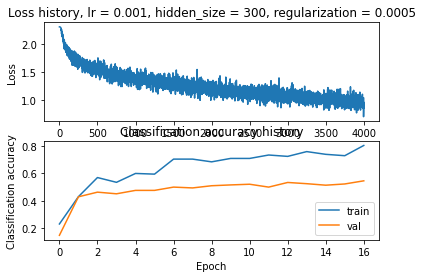

---------------------------------
Learning rate:  0.001
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302580
iteration 100 / 4000: loss 1.901560
iteration 200 / 4000: loss 1.844561
iteration 300 / 4000: loss 1.587907
iteration 400 / 4000: loss 1.589006
iteration 500 / 4000: loss 1.466195
iteration 600 / 4000: loss 1.498723
iteration 700 / 4000: loss 1.246205
iteration 800 / 4000: loss 1.575231
iteration 900 / 4000: loss 1.432378
iteration 1000 / 4000: loss 1.129387
iteration 1100 / 4000: loss 1.409834
iteration 1200 / 4000: loss 1.296471
iteration 1300 / 4000: loss 1.496993
iteration 1400 / 4000: loss 1.252679
iteration 1500 / 4000: loss 1.309914
iteration 1600 / 4000: loss 1.321699
iteration 1700 / 4000: loss 1.226408
iteration 1800 / 4000: loss 1.214138
iteration 1900 / 4000: loss 1.118485
iteration 2000 / 4000: loss 1.164105
iteration 2100 / 4000: loss 1.261106
iteration 2200 / 4000: loss 1.145637
iteration 2300 / 4000: loss 1.173663
iterati

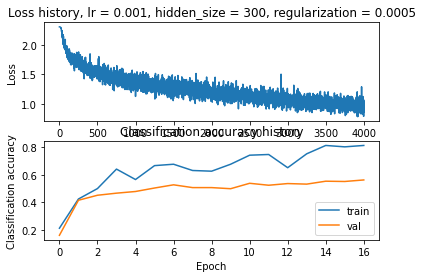

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302619
iteration 100 / 4000: loss 1.818907
iteration 200 / 4000: loss 1.703351
iteration 300 / 4000: loss 1.631539
iteration 400 / 4000: loss 1.559348
iteration 500 / 4000: loss 1.502707
iteration 600 / 4000: loss 1.514855
iteration 700 / 4000: loss 1.317535
iteration 800 / 4000: loss 1.555860
iteration 900 / 4000: loss 1.375268
iteration 1000 / 4000: loss 1.311132
iteration 1100 / 4000: loss 1.222322
iteration 1200 / 4000: loss 1.254676
iteration 1300 / 4000: loss 1.110578
iteration 1400 / 4000: loss 1.307685
iteration 1500 / 4000: loss 1.349912
iteration 1600 / 4000: loss 1.229318
iteration 1700 / 4000: loss 1.289497
iteration 1800 / 4000: loss 1.308301
iteration 1900 / 4000: loss 1.279347
iteration 2000 / 4000: loss 1.125940
iteration 2100 / 4000: loss 1.192330
iteration 2200 / 4000: loss 1.060462
iteration 2300 / 4000: loss 1.258753
iteratio

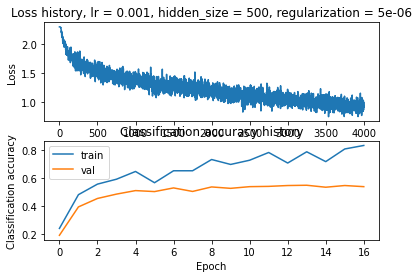

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302509
iteration 100 / 4000: loss 1.962487
iteration 200 / 4000: loss 1.708425
iteration 300 / 4000: loss 1.596125
iteration 400 / 4000: loss 1.565152
iteration 500 / 4000: loss 1.573713
iteration 600 / 4000: loss 1.421490
iteration 700 / 4000: loss 1.558646
iteration 800 / 4000: loss 1.429563
iteration 900 / 4000: loss 1.384425
iteration 1000 / 4000: loss 1.324488
iteration 1100 / 4000: loss 1.353548
iteration 1200 / 4000: loss 1.422164
iteration 1300 / 4000: loss 1.231781
iteration 1400 / 4000: loss 1.165396
iteration 1500 / 4000: loss 1.261729
iteration 1600 / 4000: loss 1.207849
iteration 1700 / 4000: loss 1.141442
iteration 1800 / 4000: loss 1.190938
iteration 1900 / 4000: loss 1.221179
iteration 2000 / 4000: loss 1.252167
iteration 2100 / 4000: loss 1.169524
iteration 2200 / 4000: loss 1.094102
iteration 2300 / 4000: loss 1.080842
iterati

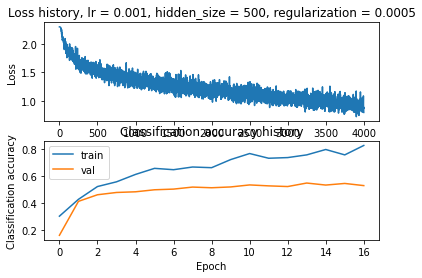

---------------------------------
Learning rate:  0.001
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302560
iteration 100 / 4000: loss 1.899035
iteration 200 / 4000: loss 1.768542
iteration 300 / 4000: loss 1.498927
iteration 400 / 4000: loss 1.636946
iteration 500 / 4000: loss 1.619208
iteration 600 / 4000: loss 1.585656
iteration 700 / 4000: loss 1.444119
iteration 800 / 4000: loss 1.500944
iteration 900 / 4000: loss 1.225156
iteration 1000 / 4000: loss 1.306366
iteration 1100 / 4000: loss 1.329304
iteration 1200 / 4000: loss 1.251026
iteration 1300 / 4000: loss 1.304904
iteration 1400 / 4000: loss 1.237568
iteration 1500 / 4000: loss 1.220585
iteration 1600 / 4000: loss 1.111743
iteration 1700 / 4000: loss 1.252469
iteration 1800 / 4000: loss 1.115298
iteration 1900 / 4000: loss 1.198739
iteration 2000 / 4000: loss 1.195899
iteration 2100 / 4000: loss 1.190539
iteration 2200 / 4000: loss 1.076625
iteration 2300 / 4000: loss 1.042705
iterati

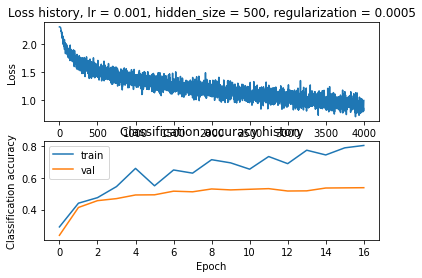

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302660
iteration 100 / 4000: loss 1.853721
iteration 200 / 4000: loss 1.589399
iteration 300 / 4000: loss 1.602004
iteration 400 / 4000: loss 1.499633
iteration 500 / 4000: loss 1.630097
iteration 600 / 4000: loss 1.502233
iteration 700 / 4000: loss 1.465539
iteration 800 / 4000: loss 1.424117
iteration 900 / 4000: loss 1.419543
iteration 1000 / 4000: loss 1.362352
iteration 1100 / 4000: loss 1.315565
iteration 1200 / 4000: loss 1.425038
iteration 1300 / 4000: loss 1.268445
iteration 1400 / 4000: loss 1.165155
iteration 1500 / 4000: loss 1.119911
iteration 1600 / 4000: loss 1.275432
iteration 1700 / 4000: loss 1.266296
iteration 1800 / 4000: loss 1.205883
iteration 1900 / 4000: loss 1.048737
iteration 2000 / 4000: loss 1.071077
iteration 2100 / 4000: loss 1.120982
iteration 2200 / 4000: loss 1.083327
iteration 2300 / 4000: loss 1.136688
iterati

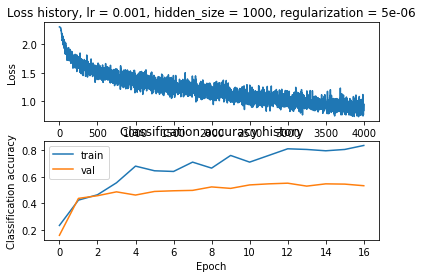

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302636
iteration 100 / 4000: loss 1.790883
iteration 200 / 4000: loss 1.770404
iteration 300 / 4000: loss 1.738242
iteration 400 / 4000: loss 1.599725
iteration 500 / 4000: loss 1.423440
iteration 600 / 4000: loss 1.503219
iteration 700 / 4000: loss 1.457673
iteration 800 / 4000: loss 1.453798
iteration 900 / 4000: loss 1.489426
iteration 1000 / 4000: loss 1.403234
iteration 1100 / 4000: loss 1.371962
iteration 1200 / 4000: loss 1.475441
iteration 1300 / 4000: loss 1.338557
iteration 1400 / 4000: loss 1.240696
iteration 1500 / 4000: loss 1.329847
iteration 1600 / 4000: loss 1.334636
iteration 1700 / 4000: loss 1.168717
iteration 1800 / 4000: loss 1.177812
iteration 1900 / 4000: loss 1.213356
iteration 2000 / 4000: loss 1.216898
iteration 2100 / 4000: loss 1.114393
iteration 2200 / 4000: loss 1.221592
iteration 2300 / 4000: loss 1.119230
iterat

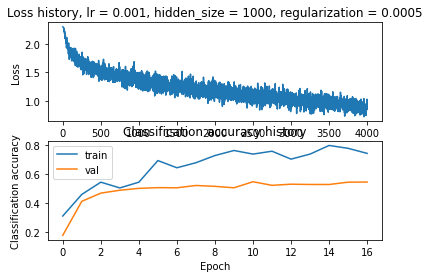

---------------------------------
Learning rate:  0.001
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302611
iteration 100 / 4000: loss 1.857251
iteration 200 / 4000: loss 1.735668
iteration 300 / 4000: loss 1.555114
iteration 400 / 4000: loss 1.460607
iteration 500 / 4000: loss 1.537233
iteration 600 / 4000: loss 1.457199
iteration 700 / 4000: loss 1.331675
iteration 800 / 4000: loss 1.607163
iteration 900 / 4000: loss 1.494604
iteration 1000 / 4000: loss 1.334299
iteration 1100 / 4000: loss 1.234435
iteration 1200 / 4000: loss 1.486433
iteration 1300 / 4000: loss 1.274903
iteration 1400 / 4000: loss 1.297894
iteration 1500 / 4000: loss 1.294244
iteration 1600 / 4000: loss 1.160676
iteration 1700 / 4000: loss 1.199962
iteration 1800 / 4000: loss 1.241652
iteration 1900 / 4000: loss 1.222076
iteration 2000 / 4000: loss 1.115829
iteration 2100 / 4000: loss 1.142949
iteration 2200 / 4000: loss 1.045974
iteration 2300 / 4000: loss 1.147290
iterat

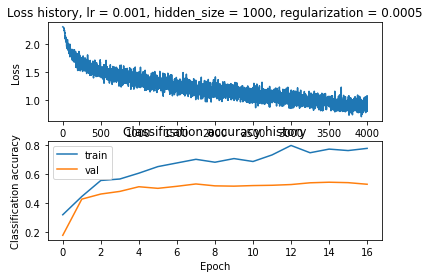

---------------------------------
Learning rate:  0.01
Size for hidden layer:  100
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302551


<ipython-input-10-e2d4f90c9d4b>:42: RuntimeWarning: overflow encountered in exp
  scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]
<ipython-input-10-e2d4f90c9d4b>:42: RuntimeWarning: invalid value encountered in true_divide
  scores = np.exp(z3) / np.sum(np.exp(z3), axis=1)[:, None]


iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss nan
iteration 2800 / 4000: loss nan
iteration 2900 / 4000: loss nan
iteration 3000 / 4000: loss nan
iteration 3100 / 4000: loss nan
iteration 3200 / 

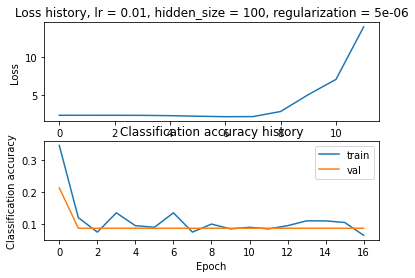

---------------------------------
Learning rate:  0.01
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302659
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

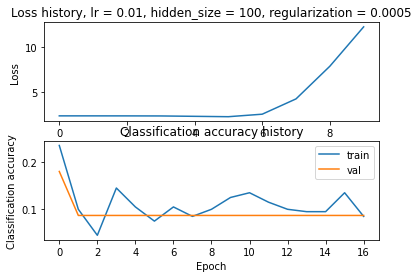

---------------------------------
Learning rate:  0.01
Size for hidden layer:  100
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302585
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

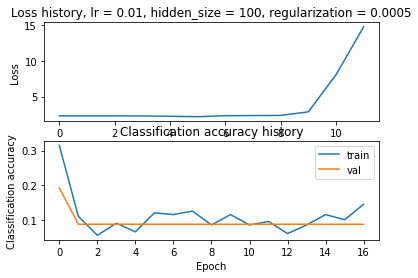

---------------------------------
Learning rate:  0.01
Size for hidden layer:  300
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302597
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss 

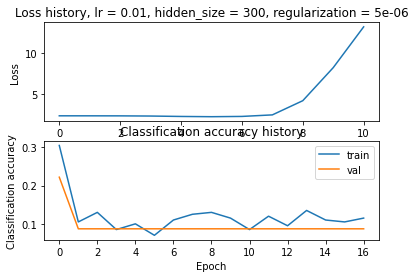

---------------------------------
Learning rate:  0.01
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302632
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

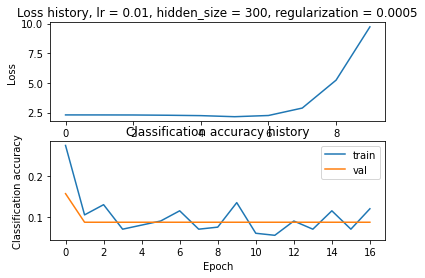

---------------------------------
Learning rate:  0.01
Size for hidden layer:  300
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302569
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

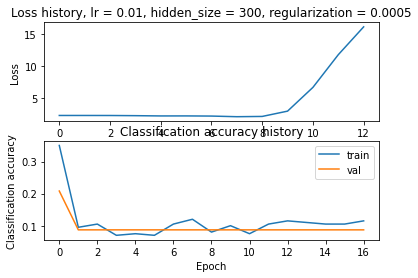

---------------------------------
Learning rate:  0.01
Size for hidden layer:  500
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302517
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss 

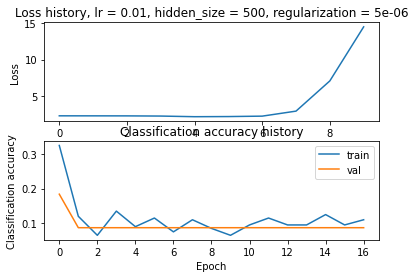

---------------------------------
Learning rate:  0.01
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302612
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

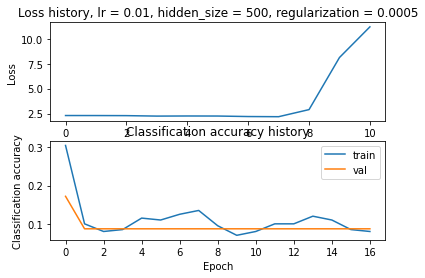

---------------------------------
Learning rate:  0.01
Size for hidden layer:  500
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302677
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

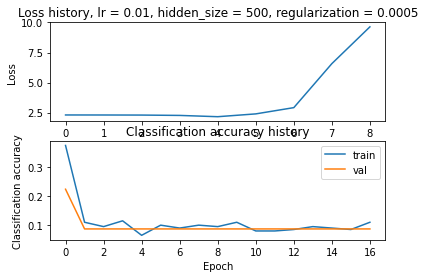

---------------------------------
Learning rate:  0.01
Size for hidden layer:  1000
Regularization strenght:  5e-06
iteration 0 / 4000: loss 2.302590
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss

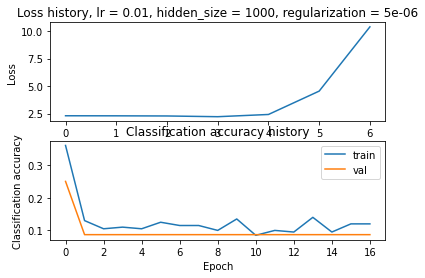

---------------------------------
Learning rate:  0.01
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302625
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: los

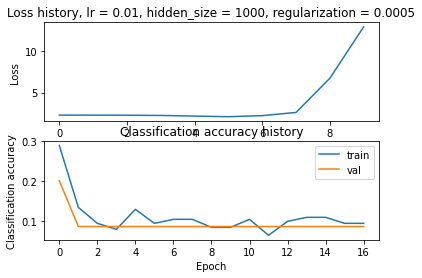

---------------------------------
Learning rate:  0.01
Size for hidden layer:  1000
Regularization strenght:  0.0005
iteration 0 / 4000: loss 2.302479
iteration 100 / 4000: loss nan
iteration 200 / 4000: loss nan
iteration 300 / 4000: loss nan
iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: los

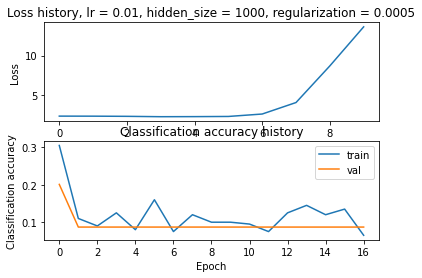

Best learning rate:  0.001
Best size for hidden layer:  300
iteration 0 / 20000: loss 1.172849
iteration 100 / 20000: loss 1.231231
iteration 200 / 20000: loss 1.215615
iteration 300 / 20000: loss 1.218089
iteration 400 / 20000: loss 1.352888
iteration 500 / 20000: loss 1.212294
iteration 600 / 20000: loss 1.206515
iteration 700 / 20000: loss 1.135299
iteration 800 / 20000: loss 1.260151
iteration 900 / 20000: loss 1.139112
iteration 1000 / 20000: loss 1.163098
iteration 1100 / 20000: loss 1.173554
iteration 1200 / 20000: loss 1.200804
iteration 1300 / 20000: loss 1.161341
iteration 1400 / 20000: loss 1.184714
iteration 1500 / 20000: loss 1.218516
iteration 1600 / 20000: loss 1.162320
iteration 1700 / 20000: loss 1.248886
iteration 1800 / 20000: loss 1.180522
iteration 1900 / 20000: loss 1.103053
iteration 2000 / 20000: loss 1.144052
iteration 2100 / 20000: loss 1.117878
iteration 2200 / 20000: loss 1.170648
iteration 2300 / 20000: loss 1.115837
iteration 2400 / 20000: loss 1.046983
it

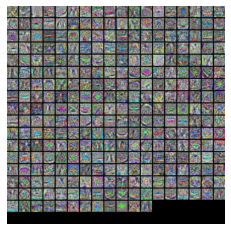

Test accuracy:  0.545


In [22]:
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

# # Train a network
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNetv4(input_size, hidden_size, num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# # Debug the training
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
#
# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()


# Visualize the weights of the network

show_net_weights(net)

# # Tune your hyperparameters
#
# **What's wrong?**. Looking at the visualizations above, we see that the loss
# is decreasing more or less linearly, which seems to suggest that the learning
# rate may be too low. Moreover, there is no gap between the training and
# validation accuracy, suggesting that the model we used has low capacity, and
# that we should increase its size. On the other hand, with a very large model
# we would expect to see more overfitting, which would manifest itself as a
# very large gap between the training and validation accuracy.
#
# **Tuning**. Tuning the hyperparameters and developing intuition for how they
# affect the final performance is a large part of using Neural Networks, so we
# want you to get a lot of practice. Below, you should experiment with
# different values of the various hyperparameters, including hidden layer size,
# learning rate, numer of training epochs, and regularization strength. You
# might also consider tuning the learning rate decay, but you should be able to
# get good performance using the default value.
#
# **Approximate results**. You should be aim to achieve a classification
# accuracy of greater than 48% on the validation set. Our best network gets
# over 52% on the validation set.
#
# **Experiment**: You goal in this exercise is to get as good of a result on
# CIFAR-10 as you can (52% could serve as a reference), with a fully-connected
# Neural Network. Feel free implement your own techniques (e.g. PCA to reduce
# dimensionality, or adding dropout, or adding features to the solver, etc.).

# **Explain your hyperparameter tuning process in the report.**

best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_acc = 0.
best_lr = None
best_reg = 0.
best_hidden_size = None
learning_rates = [1e-4, 1e-3, 0.01]
hidden_sizes = [100, 300, 500, 1000]
reg_strength = [5e-6, 5e-4] 

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        for reg in reg_strength:
            print("---------------------------------")
            print("Learning rate: ", learning_rate)
            print("Size for hidden layer: ", hidden_size)
            print("Regularization strenght: ", reg)

            input_size = 32 * 32 * 3
            num_classes = 10
            net = TwoLayerNetv4(input_size, hidden_size, num_classes)
            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=4000, batch_size=200,
                        learning_rate=learning_rate, learning_rate_decay=0.95,
                        reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val) == y_val).mean()
            print('Validation accuracy: ', val_acc)

            if val_acc > best_acc:
                best_acc = val_acc
                best_net = net
                best_lr = learning_rate
                best_hidden_size = hidden_size
                best_reg = reg

            # Plot the loss function and train / validation accuracies
            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history, lr = {}, hidden_size = {}, regularization = {}'.format(learning_rate, hidden_size, reg))
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Classification accuracy')
            plt.legend()
            plt.show()

print("Best learning rate: ", best_lr)
print("Best size for hidden layer: ", best_hidden_size)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Forgot to update the network with best parameters. Proper code is below!

# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

# Best network

Best learning rate:  0.001
Best size for hidden layer:  300
Best regularization strenght:  5e-06
iteration 0 / 20000: loss 2.302557
iteration 100 / 20000: loss 2.032665
iteration 200 / 20000: loss 1.737470
iteration 300 / 20000: loss 1.700858
iteration 400 / 20000: loss 1.691218
iteration 500 / 20000: loss 1.531886
iteration 600 / 20000: loss 1.548099
iteration 700 / 20000: loss 1.456020
iteration 800 / 20000: loss 1.481959
iteration 900 / 20000: loss 1.347555
iteration 1000 / 20000: loss 1.294178
iteration 1100 / 20000: loss 1.270384
iteration 1200 / 20000: loss 1.237687
iteration 1300 / 20000: loss 1.210233
iteration 1400 / 20000: loss 1.273739
iteration 1500 / 20000: loss 1.369253
iteration 1600 / 20000: loss 1.174806
iteration 1700 / 20000: loss 1.288330
iteration 1800 / 20000: loss 1.227310
iteration 1900 / 20000: loss 1.268596
iteration 2000 / 20000: loss 1.313696
iteration 2100 / 20000: loss 1.201349
iteration 2200 / 20000: loss 1.349413
iteration 2300 / 20000: loss 1.197710
ite

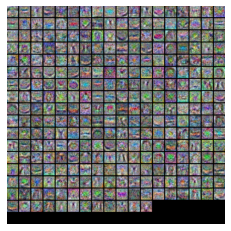

Test accuracy:  0.537


In [23]:
print("Best learning rate: ", best_lr)
print("Best size for hidden layer: ", best_hidden_size)
print("Best regularization strenght: ", best_reg)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_net = TwoLayerNetv4(input_size, best_hidden_size, num_classes)
# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=best_lr, learning_rate_decay=0.90,
            reg=best_reg, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

# Observations:

We trained with different values for learning rate, hidden size and regularisation strenght as indicated. 

1. The best accuracy is 0.537 on test dataset. The lr = 0.01, hidden size = 300 and reg strength is 5e-06.
2. Also, if the number of hidden size is increaisng, for a fixed lr, the accuracy is slightly improving. 
3. One interesting aspect is that for the highest learning rate tested, in our case 0.01, we got numerical overflow. This may be expected due to vanishing / exploding gradinets.

### Question 4: Implement multi-layer perceptron using PyTorch library (10 points)

So far, we have implemented a two-layer network by explicitly writing down the expressions for the forward and backward computations and training algorithms using simple matrix multiplication primitives from the NumPy library.

However there are many libraries available designed make experimenting with neural networks faster by abstracting away the details into re-usable modules. One such popular open-source library is PyTorch (https://pytorch.org/). In this final question we will use the PyTorch library to implement the same two-layer network we did before and train it on the Cifar-10 dataset. However, extending a two-layer network to a three or four layered one is a matter of changing two-three lines of code using PyTorch. We will take advantage of this to experiment with deeper networks to improve the performance on the CIFAR-10 classification.

To install the pytorch library follow the instruction in
https://pytorch.org/get-started/locally/ . If you have access to a Graphics Processing
Unit (GPU), you can install the gpu verison and run the exercise on GPU for faster run
times. If not, you can install the cpu version (select cuda version None) and run on the
cpu. Having gpu access is not necessary to complete the exercise.  There are good tutorials
for getting started with pytorch on their website (https://pytorch.org/tutorials/).

a) Complete the code to implement a multi-layer perceptron network in the class
`MultiLayerPerceptron`. This includes instantiating the
required layers from `torch.nn` and writing the code for forward pass. Initially you 
should write the code for the same two-layer network we have seen before.
(3 points)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
hidden_size = [1000, 100]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        
        for i in range(len(hidden_layers) - 1):
                layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
            
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        return self.layers(x)
    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

b) Complete the code to train the network. Make use of the loss function `torch.nn.CrossEntropyLoss` to compute the loss and `loss.backward()` to compute the gradients. Once gradients are computed, `optimizer.step()` can be invoked to update the model. Your should be able to achieve similar performance ($>$ 48\% accuracy on the validation set) as in Q3. Report the final validation accuracy you achieve with a two-layer network. (3 points)

In [ ]:
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # if(i>2):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        
        # set the model to train
        model.train()
        
        optimizer.zero_grad()
        
        # forward pass
        output = model(images)
        _, predicted = torch.max(output.data, 1)    
        # calculate loss
        loss = criterion(output, labels)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # reshape images to input size
            images = images.reshape(-1, input_size).to(device)
            # set the model for evaluation
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validation accuracy is: {} %'.format(100 * correct / total))

##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = MultiLayerPerceptron(input_size, hidden_size, num_classes)
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        # set the model for evaluation
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

## Improved model

In [ ]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            # we could add batch norm and dropout between the linear and the activation function
            layers.append(nn.BatchNorm1d(hidden_layers[i+1]))
            layers.append(nn.Dropout(0.3))
            layers.append(nn.PReLU())
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = self.layers(x)
        return out
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

In [ ]:
# Hyperparameters
input_size = 32 * 32 * 3
hidden_size = [1000, 100]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True


# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        # if(i>2):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        
        # set the model to train
        model.train()
        
        optimizer.zero_grad()
        
        # forward pass
        output = model(images)
        _, predicted = torch.max(output.data, 1)    
        # calculate loss
        loss = criterion(output, labels)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # reshape images to input size
            images = images.reshape(-1, input_size).to(device)
            # set the model for evaluation
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validation accuracy is: {} %'.format(100 * correct / total))

##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = MultiLayerPerceptron(input_size, hidden_size, num_classes)
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # reshape images to input size
        images = images.reshape(-1, input_size).to(device)
        # set the model for evaluation
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))